In [1]:
site_id = 13

In [2]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import plotly
import chart_studio.plotly as py
import plotly.express as px
import cufflinks as cf
cf.go_offline()

import os
import time
from pathlib import Path

import datetime as datetime
from dateutil import relativedelta

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator

from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

# Since pytrends is returning a DataFrame object, we need pandas:
import pandas as pd
import numpy as np
# Import of pytrends (needs to be pip installed first):
from pytrends.request import TrendReq

In [3]:
def MinMaxScaler(data):
    return (data-np.min(data))/(np.max(data)-np.min(data))

def Kmeans_clustering(df, clusterNum, max_iter, n_jobs):
    scaler = StandardScaler()
    scaler.fit(df)
    df_std = pd.DataFrame(data=scaler.transform(df), columns=df.columns, index=df.index)
    km_model = KMeans(n_clusters=clusterNum, max_iter=max_iter, n_jobs=n_jobs, random_state=666)
    km_model = km_model.fit(df_std)
    clusterdf= pd.DataFrame(data=km_model.labels_, columns=['ClusterNo'])
    clusterdf.index = df.index
    return clusterdf

def Kmeans_bestClusterNum(df, range_min, range_max, max_iter, n_jobs):
    silhouette_avgs = []
    sum_of_squared_distances = []
    
    ks = range(range_min,range_max+1)
    for k in ks:
        kmeans_fit = KMeans(n_clusters = k, n_jobs=n_jobs, max_iter=max_iter, random_state=666).fit(df)
        cluster_labels = kmeans_fit.labels_
        sum_of_squared_distances.append(kmeans_fit.inertia_)
        
    kn = KneeLocator(list(ks), sum_of_squared_distances, S=1.0, curve='convex', direction='decreasing')  
    plt.xlabel('k')
    plt.ylabel('sum_of_squared_distances')
    plt.title('The Elbow Method showing the optimal k')
    plt.plot(ks, sum_of_squared_distances, 'bx-')
    plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
    plt.show()
    print('Optimal clustering number:'+str(kn.knee))
    print('----------------------------')    
    
    return kn.knee

In [4]:
%%time
root = Path(r'D:\Temp\20200612\GEPIII_dataset')

train_df = pd.read_feather(root/'train.feather')
train_df_pivot = pd.read_pickle(root/'train_df_pivot.pickle.gz')
test_df = pd.read_feather(root/'test.feather')
weather_train_df = pd.read_feather(root/'weather_train.feather')
weather_test_df = pd.read_feather(root/'weather_test.feather')
building_meta_df = pd.read_feather(root/'building_metadata.feather')
new_building_meta_df = pd.read_pickle(root/'new_building_meta_df.pickle')

Wall time: 17.1 s


In [5]:
path_trends = r'C:\Users\patri\hourlyHistoricalData_pytrends\raw data'

file = 'df_daily_merged.pickle'
df_daily_merged = pd.read_pickle(os.path.join(path_trends, file))
df_trends_daily = df_daily_merged.pivot_table(columns=['geo_id', 'keyword'], index='date', values='trend')
df_trends_daily.columns = ['_'.join(col) for col in df_trends_daily.columns.values]
df_trends_daily

,CA_Adobe,CA_Google Docs,CA_Microsoft Office,CH_Adobe,CH_Google Docs,CH_Microsoft Office,GB_Adobe,GB_Google Docs,GB_Microsoft Office,IE_Adobe,...,IE_Microsoft Office,SG_Adobe,SG_Google Docs,SG_Microsoft Office,TW_Adobe,TW_Google Docs,TW_Microsoft Office,US_Adobe,US_Google Docs,US_Microsoft Office
date,,,,,,,,,,,,,,,,,,,,,
2016-01-03,76.00,13.53,23.20,83.60,0.00,19.25,64.40,18.29,34.17,26.04,...,10.73,49.20,21.12,52.00,45.00,34.78,71.25,56.96,8.74,32.68
2016-01-04,83.00,24.19,42.34,71.28,2.31,17.25,72.68,16.74,51.00,67.20,...,15.37,60.68,27.36,79.00,47.00,74.00,76.00,83.66,22.04,64.60
2016-01-05,82.00,32.39,42.34,76.56,2.31,19.75,86.48,22.94,51.00,49.56,...,15.95,51.66,21.12,58.00,90.00,48.84,82.65,84.55,26.60,69.92
2016-01-06,88.00,30.34,48.14,63.36,4.62,25.00,72.68,17.98,47.43,68.88,...,20.59,47.56,21.12,82.00,76.00,41.44,95.00,84.55,28.50,73.72
2016-01-07,83.00,31.98,58.00,51.04,0.00,19.50,86.48,22.94,47.94,56.28,...,23.49,36.08,20.64,93.00,100.00,49.58,57.00,78.32,30.78,71.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-18,33.81,15.37,18.72,21.35,0.00,4.37,30.80,14.85,18.36,5.94,...,8.28,67.32,42.00,27.01,29.07,0.00,23.18,42.12,11.60,26.13
2020-07-19,41.76,16.74,19.61,15.19,0.00,6.20,28.81,14.96,14.62,20.79,...,8.37,50.73,59.34,20.16,15.99,7.00,26.10,38.71,13.44,23.76
2020-07-20,54.72,28.21,40.28,32.34,19.00,11.60,49.58,19.38,30.10,51.66,...,27.00,66.75,62.79,41.58,17.94,8.96,55.10,74.26,19.95,52.80


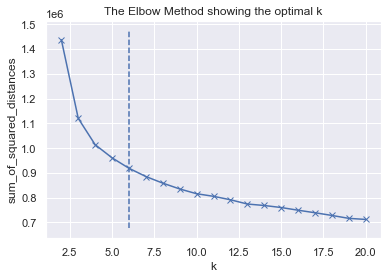

Optimal clustering number:6
----------------------------
site_id: 13
ClusterNo: 0
Amount of meters: 19


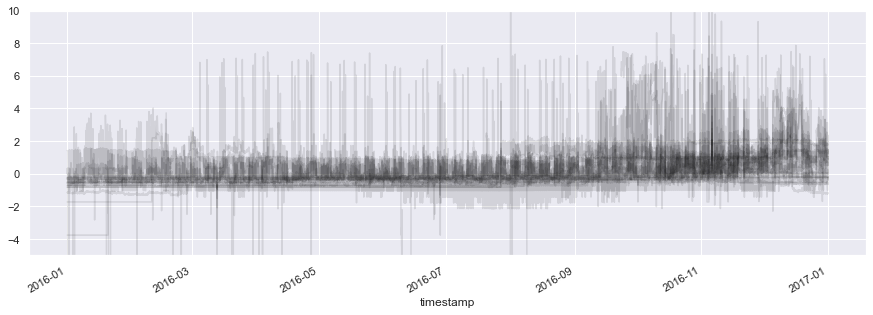

---------------------------------------------------------------------------------------------------
site_id: 13
ClusterNo: 1
Amount of meters: 85


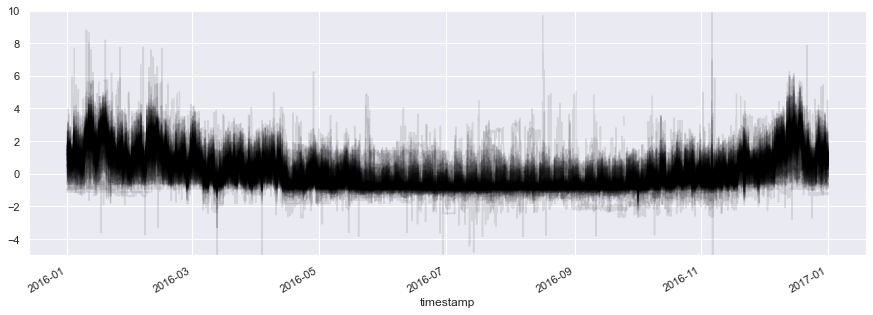

---------------------------------------------------------------------------------------------------
site_id: 13
ClusterNo: 2
Amount of meters: 60


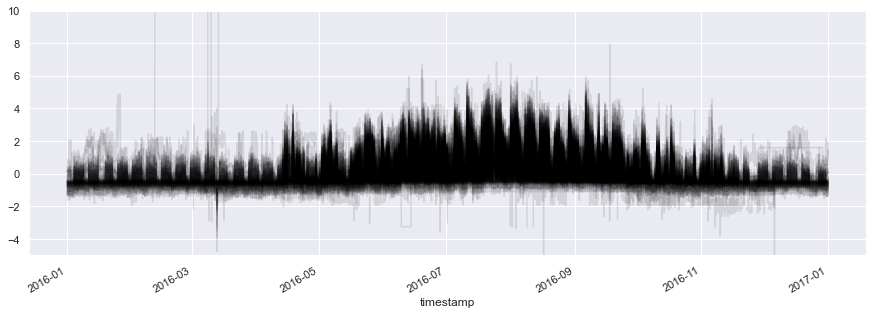

---------------------------------------------------------------------------------------------------
site_id: 13
ClusterNo: 3
Amount of meters: 75


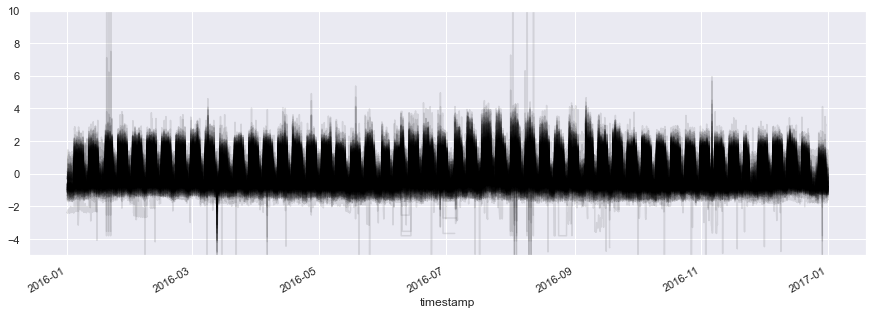

---------------------------------------------------------------------------------------------------
site_id: 13
ClusterNo: 4
Amount of meters: 14


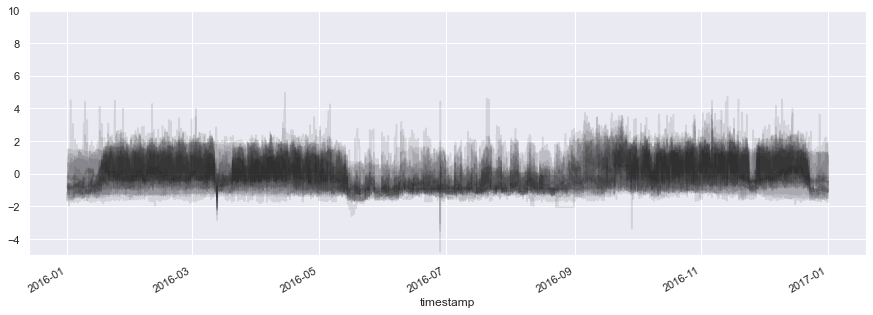

---------------------------------------------------------------------------------------------------
site_id: 13
ClusterNo: 5
Amount of meters: 56


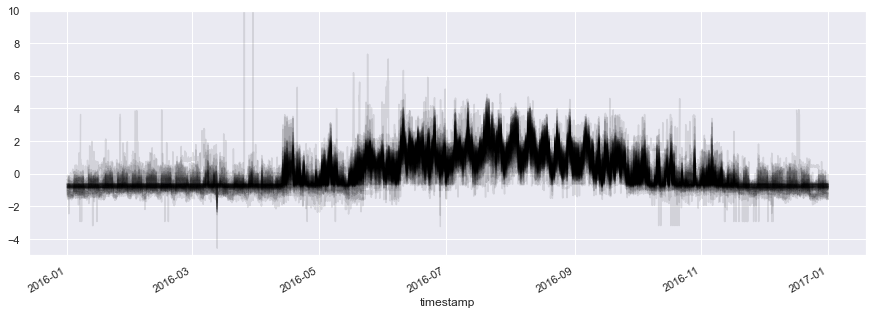

---------------------------------------------------------------------------------------------------


In [6]:
df_PM_temp = train_df_pivot.copy()
df_PM_temp = (df_PM_temp-df_PM_temp.mean())/df_PM_temp.std()
df_PM_temp = df_PM_temp.T  

df_PM_temp = df_PM_temp.loc[new_building_meta_df[new_building_meta_df['site_id']==site_id]['merged_id'].to_list()].copy()
if len(df_PM_temp)>0:
    try:
        bestClusterNum = Kmeans_bestClusterNum(df=df_PM_temp.fillna(0), range_min=2, range_max=20, max_iter=10000, n_jobs=-1)
    except:
        try:
            bestClusterNum = Kmeans_bestClusterNum(df=df_PM_temp.fillna(0), range_min=2, range_max=15, max_iter=10000, n_jobs=-1)
        except:
            try:
                bestClusterNum = Kmeans_bestClusterNum(df=df_PM_temp.fillna(0), range_min=2, range_max=10, max_iter=10000, n_jobs=-1)
            except:
                bestClusterNum = 1

    try:
        df_PM_temp['ClusterNo'] = Kmeans_clustering(df=df_PM_temp.fillna(0), clusterNum=bestClusterNum, max_iter=10000, n_jobs=-1)
    except:
        bestClusterNum = 1
        df_PM_temp['ClusterNo'] = Kmeans_clustering(df=df_PM_temp.fillna(0), clusterNum=bestClusterNum, max_iter=10000, n_jobs=-1)

    for ClusterNo in df_PM_temp['ClusterNo'].sort_values().unique():
        df_plot = df_PM_temp[df_PM_temp['ClusterNo']==ClusterNo].T.drop('ClusterNo')
        print('site_id: ' + str(site_id))    
        print('ClusterNo: ' + str(ClusterNo))    
        print('Amount of meters: ' + str(len(df_plot.T)))
        df_plot.plot(figsize=(15,5),color='black',alpha=0.1,legend=False, ylim=(-5,10))
        plt.show()
        print('---------------------------------------------------------------------------------------------------')  

In [7]:
df_cluster = df_PM_temp['ClusterNo'].reset_index()
df_cluster

,merged_id,ClusterNo
0,site13_bldg1069_meter0,3
1,site13_bldg1070_meter0,4
2,site13_bldg1070_meter1,5
3,site13_bldg1071_meter0,3
4,site13_bldg1072_meter1,5
...,...,...
304,site13_bldg1220_meter0,2
305,site13_bldg1220_meter1,2
306,site13_bldg1220_meter2,1
307,site13_bldg1221_meter0,0


ClusterNo: 0
Number of meters: 19
[0.31178823 0.13479936 0.0759847  0.05895846 0.04552398 0.04497261
 0.0383301  0.03662826 0.0260407  0.02271092 0.01557474 0.01463679
 0.01188234 0.01092018 0.01035494 0.00912606 0.00803473 0.00758712
 0.00614318 0.00596817 0.00513457]


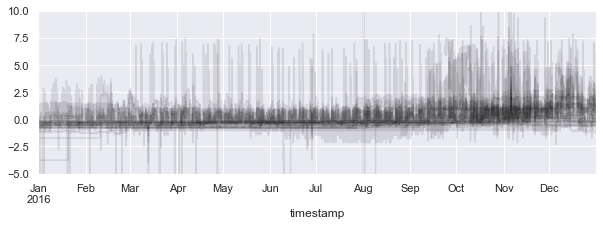

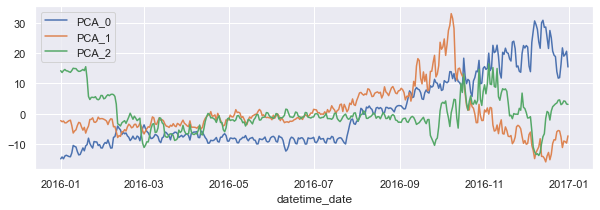

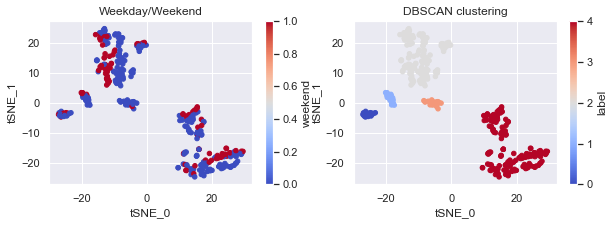

corr(IE_Adobe): 0.2473277699734228


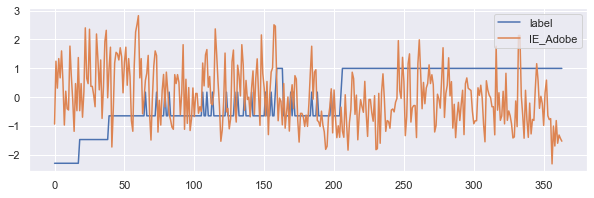

------------------------------------------------------------------------
ClusterNo: 1
Number of meters: 85
[0.73953456 0.03012864 0.02509915 0.01795878 0.01635275 0.01168545
 0.0108347  0.00950822 0.00849405 0.00661488 0.00607282 0.00530539
 0.00423125 0.00396277 0.00376555 0.00326494]


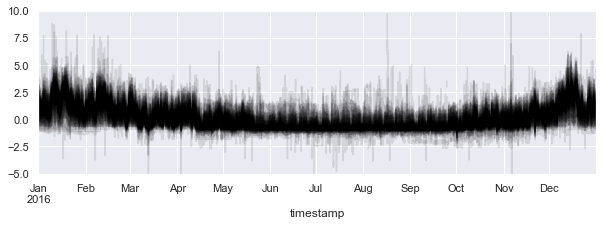

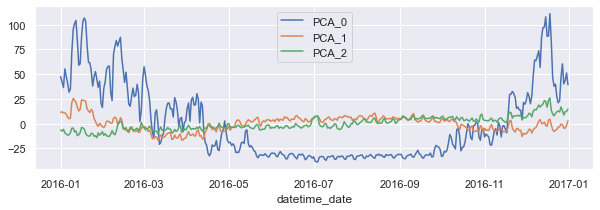

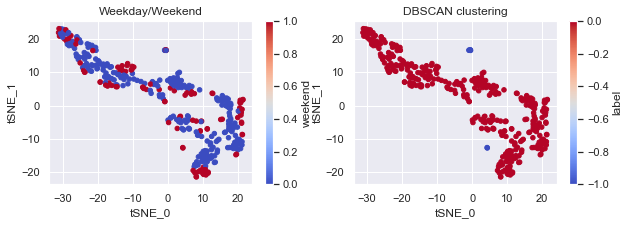

corr(US_Microsoft Office): 0.1652177509277582


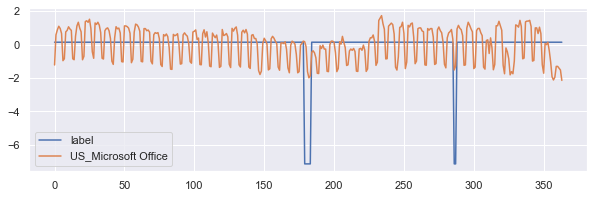

------------------------------------------------------------------------
ClusterNo: 2
Number of meters: 60
[0.61154425 0.06086377 0.03868276 0.03036221 0.02262691 0.01796999
 0.01553417 0.01278013 0.01066903 0.0094425  0.00849289 0.00767623
 0.00704549 0.00652486 0.00550929 0.00514047 0.00465248 0.0043864
 0.00407922 0.00379321 0.00367016 0.00349255 0.00328643 0.00290665]


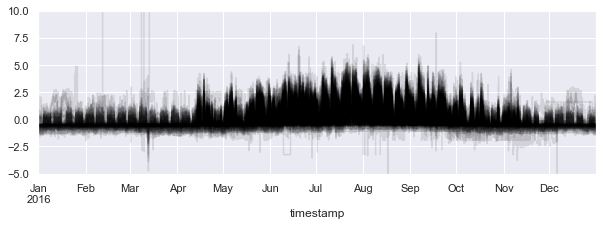

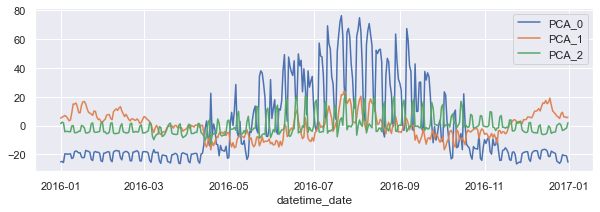

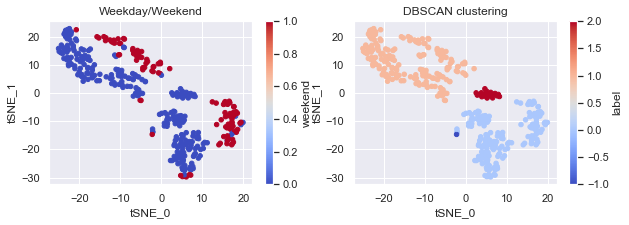

corr(TW_Google Docs): 0.22118808082461341


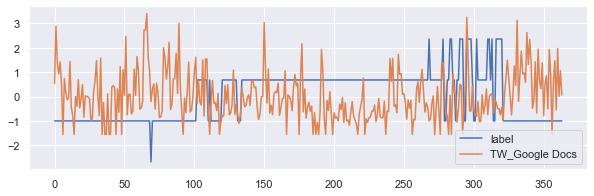

------------------------------------------------------------------------
ClusterNo: 3
Number of meters: 75
[0.5642824  0.09890102 0.03955688 0.02580129 0.01826247 0.01535021
 0.01251305 0.01222544 0.01022572 0.00911848 0.00854645 0.00749223
 0.00640446 0.00586379 0.00567566 0.00539358 0.0049373  0.00447228
 0.00438915 0.00405742 0.00386095 0.00362092 0.00339458 0.00328952
 0.00319913 0.00289498 0.00284035 0.00266995 0.00259805 0.00249541
 0.00245546 0.00233197 0.00214722]


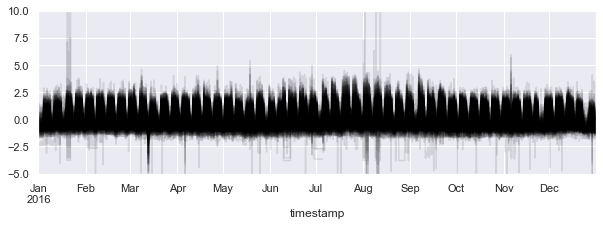

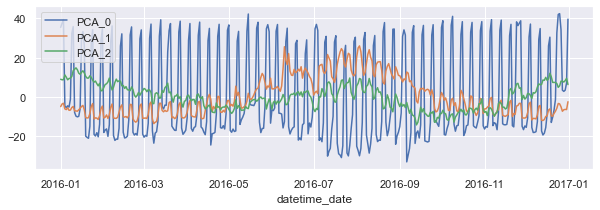

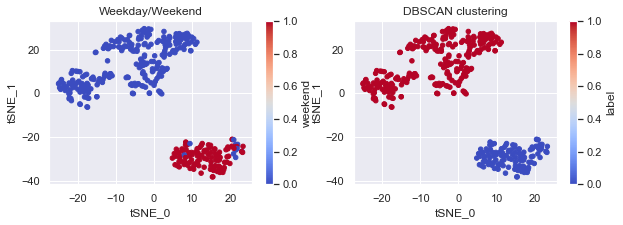

corr(US_Microsoft Office): 0.8526502617910366


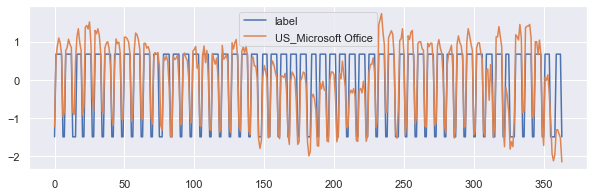

------------------------------------------------------------------------
ClusterNo: 4
Number of meters: 14
[0.5012082  0.10950868 0.07364559 0.04898648 0.02691491 0.02504457
 0.01955687 0.01563158 0.01391355 0.01263692 0.01147543 0.00923026
 0.00802198 0.00763574 0.00574273 0.00533602 0.00470385 0.0043567 ]


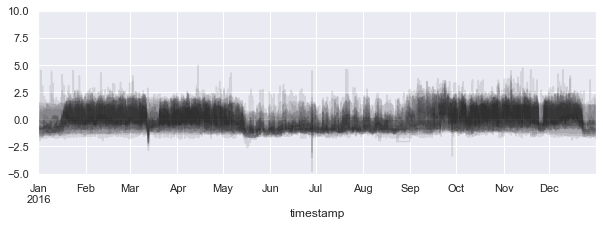

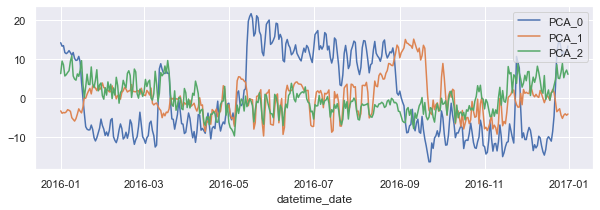

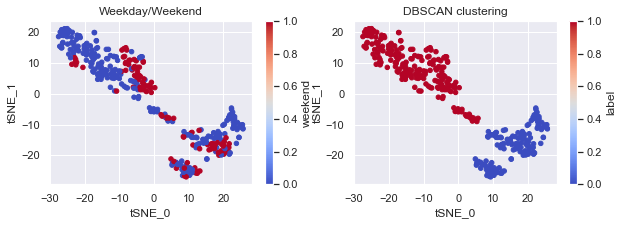

corr(US_Google Docs): 0.5734440463648681


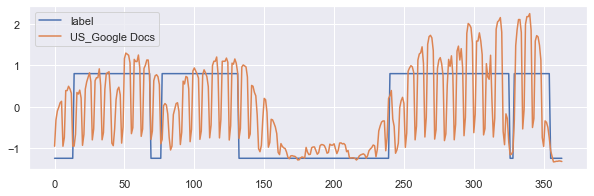

------------------------------------------------------------------------
ClusterNo: 5
Number of meters: 56
[0.79896396 0.03270691 0.01766563 0.01317221 0.01288995 0.01192255
 0.00789462 0.00612398]


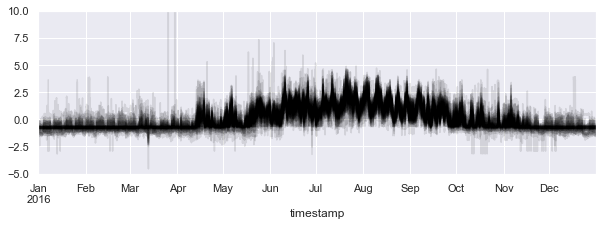

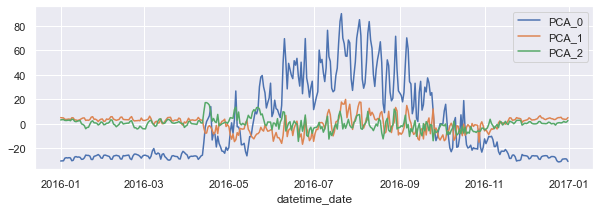

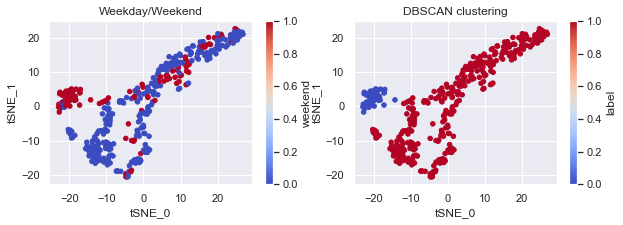

corr(US_Microsoft Office): 0.39214854036822194


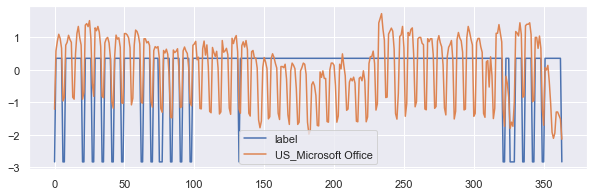

------------------------------------------------------------------------


In [9]:
for ClusterNo in df_cluster['ClusterNo'].sort_values().unique():
    
    print('ClusterNo: ' + str(ClusterNo))
    list_ClusterNo = df_cluster.loc[df_cluster['ClusterNo']==ClusterNo, 'merged_id'].to_list()
    
    print('Number of meters: ' + str(len(list_ClusterNo)))
    
    df_plot = train_df_pivot[list_ClusterNo].copy()
    df_plot = (df_plot - df_plot.mean()) / df_plot.std()
    df_plot.plot(figsize=(10,3),color='black',alpha=0.1,legend=False, ylim=(-5,10))
    
    df_plot['datetime_date'] = df_plot.index.date
    df_plot['datetime_hour'] = df_plot.index.hour
    df_plot = df_plot.pivot_table(index='datetime_date', columns=['datetime_hour'], values=list_ClusterNo)
    df_plot = df_plot.sort_index()
    #df_plot = df_plot.dropna()
    df_plot = df_plot.select_dtypes(exclude=['object', 'boolean'])

    var_components = 0.9

    pca = PCA(n_components=var_components)
    pca.fit(df_plot.fillna(0))

    print(pca.explained_variance_ratio_)

    df_pca = pd.DataFrame(pca.transform(df_plot.fillna(0)))
    df_pca['sum'] = df_pca.sum(axis=1)
    df_pca.columns = 'PCA_' + df_pca.columns.astype('str')
    df_pca.index = df_plot.index
    df_pca.iloc[:, :3].plot(figsize=(10,3))
    plt.show()

    n_components = 2

    tSNE = TSNE(n_components=n_components)

    df_tSNE = pd.DataFrame(tSNE.fit_transform(df_pca))
    df_tSNE['sum'] = df_tSNE.sum(axis=1)
    df_tSNE.columns = 'tSNE_' + df_tSNE.columns.astype('str')
    df_tSNE.index = df_plot.index

    df_plot = df_tSNE.copy()
    df_plot['weekend'] = 1
    df_plot.loc[pd.to_datetime(df_pca.index).dayofweek<5, 'weekend'] = 0

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    df_plot.plot(kind='scatter', x='tSNE_0', y='tSNE_1', c='weekend', colormap='coolwarm', title='Weekday/Weekend', ax=axes[0])
    
    # Compute DBSCAN
    db = DBSCAN(eps=0.3, min_samples=10).fit(df_plot[['tSNE_0', 'tSNE_1']])
    df_plot['label'] = db.fit_predict((df_plot[['tSNE_0', 'tSNE_1']]-df_plot[['tSNE_0', 'tSNE_1']].mean())/df_plot[['tSNE_0', 'tSNE_1']].std())
    df_plot.plot(kind='scatter', x='tSNE_0', y='tSNE_1', c='label', colormap='coolwarm', title='DBSCAN clustering', ax=axes[1])
    plt.show()
    
    series_label = df_plot['label'].reset_index()
    series_label['datetime_date'] = pd.to_datetime(series_label['datetime_date'])
    df_temp = series_label.merge(df_trends_daily.reset_index(), left_on='datetime_date', right_on='date')

    df_corr = df_temp.corr()
    series_corr = df_corr['label'].drop('label',axis=0).abs().sort_values(ascending=False)

    df_plot = df_temp[['label', series_corr.index[0]]].copy()
    df_plot = (df_plot-df_plot.mean())/df_plot.std()
    print('corr('+ series_corr.index[0] + '): ' + str(series_corr.iloc[0]))
    df_plot.plot(figsize=(10,3))    
    plt.show()
    
    print('------------------------------------------------------------------------')    